In [ ]:
library(coloc)
library(LDlinkR)
library(tidyverse)
library(data.table)
library(parallel)
library(GenomicRanges)
library(rtracklayer)
library(locuszoomr)
library(EnsDb.Hsapiens.v75)
library(ggpubr)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(gridExtra)
library(cowplot)
library(patchwork)

In [ ]:
## Set location of nominal fastQTL result files
eqtl_path <- '../data/brain_eqtl/'

ex <- paste0(eqtl_path,'Excitatory.neurons.')
inh <- paste0(eqtl_path,'Inhibitory.neurons.')
oli <- paste0(eqtl_path,'Oligodendrocytes.')
opc <- paste0(eqtl_path,'OPCs...COPs.')
micro <- paste0(eqtl_path,'Microglia.')
astro <- paste0(eqtl_path,'Astrocytes.')
endo <- paste0(eqtl_path,'Endothelial.cells.')
peri <- paste0(eqtl_path,'Pericytes.')

In [ ]:
snp_pos = fread('../data/brain_eqtl/snp_pos.txt.gz', sep='\t')

# Process GWAS

In [49]:
selected_trait = 'scz'

In [ ]:
if(selected_trait=='scz'){
sumstats <- fread('../brain_coloc/gwas/scz/PGC3_SCZ_wave3.european.autosome.public.v3.vcf.tsv.gz', skip=73, sep='\t') %>%
  mutate(CHR=paste0('chr',CHROM)) %>% 
  filter(!is.na(PVAL)) %>% 
  mutate(beta=BETA,
         se=SE) %>% 
  dplyr::select(variant_id=ID,p_value=PVAL,chr=CHR,bp_b37=POS,effect_allele=A1,other_allele=A2,beta,se)


  if(file.exists('../brain_coloc/gwas/scz/loci_LDlinkR.r2.0.1.EUR.txt')) {
    loci <- read_tsv('../brain_coloc/gwas/scz/loci_LDlinkR.r2.0.1.EUR.txt')
  }
}

In [51]:
head(sumstats)

variant_id,p_value,chr,bp_b37,effect_allele,other_allele,beta,se
<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
rs62513865,0.4847,chr8,101592213,C,T,0.011997738,0.0171
rs79643588,0.5605,chr8,106973048,G,A,-0.008596847,0.0148
rs17396518,0.8145,chr8,108690829,T,G,-0.002102208,0.0087
rs983166,0.5704,chr8,108681675,A,C,0.004897985,0.0087
rs28842593,0.7488,chr8,103044620,T,C,-0.003897586,0.0121
rs7014597,0.5034,chr8,104152280,G,C,0.007898723,0.0117


In [11]:
if(!file.exists('../brain_coloc/gwas/scz/loci_LDlinkR.r2.0.1.EUR.txt')){
  loci <- readxl::read_xlsx('../brain_coloc/gwas/scz/Supplementary Table 2.xlsx', sheet='replication results') %>% filter(`P-comb`<5e-8) %>%  
    mutate(locus=paste0('chr',CHR,':',left,'-',right)) %>% dplyr::rename(locus_name=locus) %>% mutate(start=BP,end=BP) %>%  
    mutate(GWAS_snp=SNP,GWAS_snp_pos=paste0('chr',CHR,':',BP))
}

In [ ]:
if(!file.exists('../brain_coloc/gwas/scz/loci_LDlinkR.r2.0.1.EUR.txt')){
  proxy_snps <- lapply(loci$GWAS_snp_pos,LDlinkR::LDproxy,pop = "EUR", r2d = "r2", token = '72edb9cc22c9', file = FALSE)
  saveRDS(proxy_snps,'../brain_coloc/gwas/scz/loci_LDlinkR.allSNPs.EUR.rds')
}

In [17]:
if(!file.exists('../brain_coloc/gwas/scz/loci_LDlinkR.r2.0.1.EUR.txt')){
  loci <- lapply(proxy_snps,function(x){
    if(nrow(x)>1){
      x <- filter(x,R2>=0.1) 
      chr <- x$Coord %>% gsub(':.+','',.) %>% unique()
      pos <- x$Coord %>% gsub('chr[0-9]{1,2}:','',.) %>% as.numeric()
      locus_name <- paste0(chr,':',min(pos),'_',max(pos))
      top_snp_df <- filter(x,Distance==0) 
      top_snp <- top_snp_df %>% pull(RS_Number)
      top_snp_pos <- top_snp_df %>% pull(Coord)
      locus <- tibble(GWAS_snp=top_snp,GWAS_snp_pos=top_snp_pos,locus_name=locus_name,chrom=chr,start=min(pos),end=max(pos))
      return(locus)
    }
    else{
      return(NULL)
    }
  }) %>% bind_rows()
  write_tsv(loci,'../brain_coloc/gwas/scz/loci_LDlinkR.r2.0.1.EUR.txt')
}


In [37]:
if(!file.exists('../brain_coloc/gwas/scz/closest.protein.coding.bed')){
  sumstats_min <- sumstats %>% dplyr::select(chr,variant_id,bp_b37,beta) %>%
     mutate(chr=paste0('chr', chr))
}

In [39]:
if(!file.exists('../brain_coloc/gwas/scz/closest.protein.coding.bed')){
  gwas_snp <- tibble(GWAS_SNP_pos=unique(loci$GWAS_snp_pos)) %>% 
    separate(GWAS_SNP_pos,into=c('chr','bp_b37'),sep=':') %>% 
    mutate(end=bp_b37) %>% 
    mutate(bp_b37=as.numeric(bp_b37)) %>% 
    left_join(.,sumstats_min,by=c('chr','bp_b37')) %>% 
    arrange(chr,bp_b37) %>% 
    write_tsv(.,'../brain_coloc/gwas/scz/scz_GWAS_index_snps.v2.bed',col_names = FALSE)
}

In [47]:
cd data/gwas/scz
ln -s ../../gencode/gencode.v39lift37.annotation.protein_coding.1_22.bed .

ml bedtools/2.25.0-goolf-1.7.20
bedtools closest -d -wa -a scz_GWAS_index_snps.v2.bed -b gencode.v39lift37.annotation.protein_coding.1_22.bed > closest.protein.coding.bed

seqnames,start,end,gene_label
<chr>,<int>,<int>,<chr>
chr14,53323986,53419153,FERMT2_ENSG00000073712


In [52]:
closest <- fread(paste0('../brain_coloc/gwas/',selected_trait,'/closest.protein.coding.bed'),sep='\t', header=FALSE) %>% 
  setNames(c('chr_snp','start_snp','end_snp','GWAS_snp','beta','chr_gene','start_gene','end_gene','gene','distance')) %>% 
  mutate(GWAS_snp_pos=paste0(chr_snp,':',start_snp)) %>% 
  dplyr::select(GWAS_snp,GWAS_snp_pos,gene,beta,distance) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_') %>% 
  add_count(GWAS_snp) %>% 
  group_by(GWAS_snp) %>% 
  mutate(locus_name_gene=ifelse(n==1,symbol,paste0(symbol,collapse=' - '))) %>% 
  ungroup() %>% 
  dplyr::select(GWAS_snp_pos,locus_name_gene,beta_top_GWAS=beta) %>% 
  unique() %>% arrange(-abs(beta_top_GWAS))
loci <- left_join(loci,closest,by='GWAS_snp_pos')

In [54]:
dim(loci)

[1] 326   8

In [55]:
head(loci)

GWAS_snp,GWAS_snp_pos,locus_name,chrom,start,end,locus_name_gene,beta_top_GWAS
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
rs140365013,chr6:27523869,chr6:27024687_28023751,chr6,27024687,28023751,ZNF184,0.21000157
rs58120505,chr7:2029867,chr7:1806591_2346115,chr7,1806591,2346115,MAD1L1 - ENSG00000286192,0.08960302
rs12571643,chr10:104520277,chr10:104059740_104973317,chr10,104059740,104973317,WBP1L,0.10240315
rs4702,chr15:91426560,chr15:91392256_91443059,chr15,91392256,91443059,FURIN,0.08430438
rs1790135,chr12:123669235,chr12:123254538_123997461,chr12,123254538,123997461,MPHOSPH9,0.07369646
rs13107325,chr4:103188709,chr4:102702364_103685218,chr4,102702364,103685218,SLC39A8,-0.15870269


# Run coloc

In [56]:
# eqtl_ex <- prepare_eqtl(micro,chrom_locus,sumstats_locus)
fun <- function(x){strsplit(x, '_')[[1]][2]}
prepare_eqtl_ibsep <- function(eqtl_path,ibsep_name,chrom_locus,sumstats_locus){
  # original eqtl
  file <- paste0(eqtl_path,gsub('chr','',chrom_locus),'.gz')
  eqtl <- data.table::fread(file,header = FALSE,data.table=FALSE,nThread = 1) %>% 
    dplyr::select(gene=V1,SNP=V2,p_eqtl=V4,beta_eqtl=V5) %>%
    inner_join(.,snp_pos,by='SNP') %>%
    dplyr::filter(SNP_id_hg19%in%sumstats_locus$SNP_id_hg19) %>%
    mutate(gene_id=sapply(gene, function(x){strsplit(x, '_')[[1]][2]})) %>%
    mutate(se_eqtl=abs(beta_eqtl/qnorm(p_eqtl/2)))
  if(nrow(eqtl)==0){
      message('nrow(eqtl)==0')
  }
    
  # ibsep
  file <- sprintf('../data/brain_data/merged_sumstats/by_chrom_gene/%s/%s.csv', chrom_locus, ibsep_name)
  
  ibsep <- data.table::fread(file, header=TRUE, nThread=1) %>%
    dplyr::select(SNP=SNP_SC, A1, A2, gene_id=GENEID_SC, BETA_BLUE, SE_BLUE, PVAL_BLUE)

  # merge eqtl and ibsep
  merged <- inner_join(eqtl,ibsep,by=c('gene_id', 'SNP'))
  merged <- merged %>%
    mutate(BETA_BLUE=case_when(
        (A2==effect_allele) ~ BETA_BLUE,
        (A1==effect_allele) ~ -BETA_BLUE
        ))
  merged <- merged[(is.na(merged$BETA_BLUE)==FALSE)&(is.na(merged$SE_BLUE)==FALSE),]
  merged <- merged %>%
    add_count(gene) %>% 
    dplyr::filter(n>10)
    
  return(merged)
}

In [57]:
#  ex_coloc <- run_coloc(eqtl_ex,'Excitatory neurons',sumstats_locus)
run_coloc <- function(tissue_sumstats,tissue_name,sumstats_locus){
  
  if(nrow(tissue_sumstats)==0){
    return (NULL)
  }
  
  out <- lapply(unique(tissue_sumstats$gene),function(x){
    message(x)
    tissue_sumstats_gene <- dplyr::filter(tissue_sumstats,gene==x)
    sumstats_locus_gene <- sumstats_locus %>% inner_join(.,tissue_sumstats_gene,by='SNP_id_hg19')
    sumstats_locus_gene <- sumstats_locus_gene[!duplicated(sumstats_locus_gene$SNP_id_hg19),] # remove duplicated SNPs
    
    if (nrow(sumstats_locus_gene)>0){

       coloc_res_pval <- coloc.abf(
       dataset1=list(beta=sumstats_locus_gene$beta,
                     varbeta=sumstats_locus_gene$se^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     type="cc"),
       dataset2=list(beta=sumstats_locus_gene$beta_eqtl,
                     varbeta=sumstats_locus_gene$se_eqtl^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     sdY=1,
                     type="quant"))$summary %>% 
       as.data.frame()
    colnames(coloc_res_pval) <- x
    
    #Get direction of effect for all SNPs at the locus
    sumstats_locus_gene <- sumstats_locus_gene %>% 
      mutate(direction=case_when(
      (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ sign(beta*beta_eqtl),
      (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -sign(beta*beta_eqtl),
    TRUE ~ 0))
   
   #Get Proportion of positive direction
   direction_prop <- sumstats_locus_gene %>% 
     summarise(prop_pos_direction=sum(direction==1)/n()) %>% 
     setNames(x) %>% 
     as.data.frame()
   rownames(direction_prop) <- 'prop_pos_direction'
   
   direction_sign <- sumstats_locus_gene %>% 
     #Take SNP with strongest evidence of an effect on gene expression
     dplyr::filter(p_eqtl==min(p_eqtl)) %>% 
     slice_min(n=1,p_value,with_ties=FALSE) %>% 
     summarise(direction=direction,
               beta_gwas=case_when(
                    (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ beta,
                    (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -beta
                    ),
              beta_eqtl=beta_eqtl,
               beta_smr=case_when(
                    direction== 1  ~ abs(beta)/abs(beta_eqtl),
                    direction== -1  ~ -(abs(beta)/abs(beta_eqtl))
                 ),
               ) %>% 
     t() %>% 
     as.data.frame()
   colnames(direction_sign) <- x
   
    #Add direction of effect to coloc results
    coloc_res_pval <- rbind(coloc_res_pval,direction_sign,direction_prop)

    return(coloc_res_pval)
    }
    else{
      return (NULL)
    }
    
})
  
  out_pvalue <- out %>% 
    bind_cols() %>% 
    t() %>% 
    as.data.frame() %>% 
    rownames_to_column('gene') %>% 
    as_tibble() %>% 
    arrange(-PP.H4.abf) %>% 
    mutate(tissue=tissue_name)
  
  return(out_pvalue)
}

#  ex_coloc <- run_coloc(eqtl_ex,'Excitatory neurons',sumstats_locus)
run_coloc_ibsep <- function(tissue_sumstats,tissue_name,sumstats_locus){
  
  if(nrow(tissue_sumstats)==0){
    return (NULL)
  }

  out <- lapply(unique(tissue_sumstats$gene),function(x){
    message(x)
    tissue_sumstats_gene <- dplyr::filter(tissue_sumstats,gene==x)
    sumstats_locus_gene <- sumstats_locus %>% inner_join(.,tissue_sumstats_gene,by='SNP_id_hg19')
    sumstats_locus_gene <- sumstats_locus_gene[!duplicated(sumstats_locus_gene$SNP_id_hg19),] # remove duplicated SNPs
    # message(any(duplicated(sumstats_locus_gene$SNP_id_hg19)))

    if (nrow(sumstats_locus_gene)>0){

       coloc_res_pval <- coloc.abf(
       dataset1=list(beta=sumstats_locus_gene$beta,
                     varbeta=sumstats_locus_gene$se^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     type="cc"),
       dataset2=list(beta=sumstats_locus_gene$BETA_BLUE,
                     varbeta=sumstats_locus_gene$SE_BLUE^2,
                     snp=sumstats_locus_gene$SNP,
                     position=sumstats_locus_gene$bp_b37,
                     sdY=1,
                     type="quant"))$summary %>% 
       as.data.frame()
    colnames(coloc_res_pval) <- x
    
    #Get direction of effect for all SNPs at the locus
    sumstats_locus_gene <- sumstats_locus_gene %>% 
      mutate(direction=case_when(
      (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ sign(beta*BETA_BLUE),
      (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -sign(beta*BETA_BLUE),
    TRUE ~ 0))
   
   #Get Proportion of positive direction
   direction_prop <- sumstats_locus_gene %>% 
     summarise(prop_pos_direction=sum(direction==1)/n()) %>% 
     setNames(x) %>% 
     as.data.frame()
   rownames(direction_prop) <- 'prop_pos_direction'
   
   direction_sign <- sumstats_locus_gene %>% 
     #Take SNP with strongest evidence of an effect on gene expression
     dplyr::filter(PVAL_BLUE==min(PVAL_BLUE)) %>% 
     slice_min(n=1,p_value,with_ties=FALSE) %>% 
     summarise(direction=direction,
               beta_gwas=case_when(
                    (effect_allele.x==effect_allele.y & other_allele.x==other_allele.y)  ~ beta,
                    (effect_allele.x==other_allele.y & other_allele.x==effect_allele.y)  ~ -beta
                    ),
              beta_blue=BETA_BLUE,
               beta_smr=case_when(
                    direction== 1  ~ abs(beta)/abs(BETA_BLUE),
                    direction== -1  ~ -(abs(beta)/abs(BETA_BLUE))
                 ),
               ) %>% 
     t() %>% 
     as.data.frame()
   colnames(direction_sign) <- x
   
    #Add direction of effect to coloc results
    coloc_res_pval <- rbind(coloc_res_pval,direction_sign,direction_prop)

    return(coloc_res_pval)
    }
    else{
      return (NULL)
    }
    
})
  
  out_pvalue <- out %>% 
    bind_cols() %>% 
    t() %>% 
    as.data.frame() %>% 
    rownames_to_column('gene') %>% 
    as_tibble() %>% 
    arrange(-PP.H4.abf) %>% 
    mutate(tissue=tissue_name)
  
  return(out_pvalue)
}

In [ ]:
## ibsep
t0 = Sys.time()
coloc_ibsep_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- dplyr::filter(sumstats,chr==chrom_locus) %>% 
    dplyr::filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_ex <- prepare_eqtl_ibsep(ex,'allgenes_Excitatory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_inh <- prepare_eqtl_ibsep(inh,'allgenes_Inhibitory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_oli <- prepare_eqtl_ibsep(oli,'allgenes_Oligodendrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_opc <- prepare_eqtl_ibsep(opc,'allgenes_OPCs_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_micro <- prepare_eqtl_ibsep(micro,'allgenes_Microglia_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_astro <- prepare_eqtl_ibsep(astro,'allgenes_Astrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_endo <- prepare_eqtl_ibsep(endo,'allgenes_Endothelial_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_peri <- prepare_eqtl_ibsep(peri,'allgenes_Pericytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  ex_coloc <- run_coloc_ibsep(eqtl_ex,'Excitatory neurons',sumstats_locus)
  inh_coloc <- run_coloc_ibsep(eqtl_inh,'Inhibitory neurons',sumstats_locus)
  oli_coloc <- run_coloc_ibsep(eqtl_oli,'Oligodendrocytes',sumstats_locus)
  opc_coloc <- run_coloc_ibsep(eqtl_opc,'OPCs / COPs',sumstats_locus)
  micro_coloc <- run_coloc_ibsep(eqtl_micro,'Microglia',sumstats_locus)
  astro_coloc <- run_coloc_ibsep(eqtl_astro,'Astrocytes',sumstats_locus)
  endo_coloc <- run_coloc_ibsep(eqtl_endo,'Endothelial cells',sumstats_locus)
  peri_coloc <- run_coloc_ibsep(eqtl_peri,'Pericytes',sumstats_locus)
  
  pval_eqtl <- rbind(ex_coloc,inh_coloc,oli_coloc,
                     opc_coloc,micro_coloc,astro_coloc,endo_coloc,peri_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 36,mc.preschedule = FALSE)
t1 = Sys.time()

In [62]:
t1 - t0

Time difference of 41.41727 mins

In [64]:
coloc_ibsep_results_all_success = list()
n = 1
for(i in 1:length(coloc_ibsep_results_all)){
    if(!is.null(dim(coloc_ibsep_results_all[[i]]))==TRUE){
        coloc_ibsep_results_all_success[[n]] = coloc_ibsep_results_all[[i]]
        n = n + 1
    }
}
length(coloc_ibsep_results_all_success)

[1] 286

In [65]:
coloc_ibsep_results_all_df <- coloc_ibsep_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')

In [66]:
dim(coloc_ibsep_results_all_df)

[1] 27709    21

In [67]:
fwrite(coloc_ibsep_results_all_df, sprintf('../data/brain_coloc/result/%s_ibsep.csv', selected_trait), sep='\t')

In [ ]:
## ori eqtl
t0 = Sys.time()
coloc_eqtl_results_all <- mclapply(1:nrow(loci),function(i){

  #Get coordinates from the GWAS locus
  chrom_locus <- loci$chrom[i]
  start <- loci$start[i] %>% as.numeric()
  end <- loci$end[i] %>% as.numeric()
  
  closest_gene_locus <- loci$locus_name_gene[i]
  beta_top_GWAS_locus <- loci$beta_top_GWAS[i]
  GWAS_snp_name <- loci$GWAS_snp[i]
  GWAS_snp_pos_name <- loci$GWAS_snp_pos[i]

  #Keep GWAS sumstats of SNPs in the locus
  sumstats_locus <- filter(sumstats,chr==chrom_locus) %>% 
    filter(bp_b37>=start & bp_b37<=end) %>% 
    dplyr::mutate(SNP_id_hg19=paste0(chr,':',bp_b37))

  #Preparing eQTL files - keeping SNPs from the eQTL data that match SNPs in the GWAS locus
  eqtl_ex <- prepare_eqtl_ibsep(ex,'allgenes_Excitatory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_inh <- prepare_eqtl_ibsep(inh,'allgenes_Inhibitory_neurons_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_oli <- prepare_eqtl_ibsep(oli,'allgenes_Oligodendrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_opc <- prepare_eqtl_ibsep(opc,'allgenes_OPCs_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_micro <- prepare_eqtl_ibsep(micro,'allgenes_Microglia_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_astro <- prepare_eqtl_ibsep(astro,'allgenes_Astrocytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_endo <- prepare_eqtl_ibsep(endo,'allgenes_Endothelial_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)
  eqtl_peri <- prepare_eqtl_ibsep(peri,'allgenes_Pericytes_eqtl_and_blue_pval1e-10_tau1_truncorr',chrom_locus,sumstats_locus)

  #Running colocalization analysis
  ex_coloc <- run_coloc(eqtl_ex,'Excitatory neurons',sumstats_locus)
  inh_coloc <- run_coloc(eqtl_inh,'Inhibitory neurons',sumstats_locus)
  oli_coloc <- run_coloc(eqtl_oli,'Oligodendrocytes',sumstats_locus)
  opc_coloc <- run_coloc(eqtl_opc,'OPCs / COPs',sumstats_locus)
  micro_coloc <- run_coloc(eqtl_micro,'Microglia',sumstats_locus)
  astro_coloc <- run_coloc(eqtl_astro,'Astrocytes',sumstats_locus)
  endo_coloc <- run_coloc(eqtl_endo,'Endothelial cells',sumstats_locus)
  peri_coloc <- run_coloc(eqtl_peri,'Pericytes',sumstats_locus)
  
  pval_eqtl <- rbind(ex_coloc,inh_coloc,oli_coloc,
                     opc_coloc,micro_coloc,astro_coloc,endo_coloc,peri_coloc)
  
  if(!is.null(pval_eqtl)){
    pval_eqtl <- pval_eqtl %>% 
      mutate(type='eQTL',
           locus=loci$locus_name[i],
           coloc_method='beta') %>% 
      mutate(closest_gene=closest_gene_locus,
             beta_top_GWAS=beta_top_GWAS_locus,
             GWAS_snp=GWAS_snp_name,
             GWAS_snp_pos=GWAS_snp_pos_name)
  }
  results <- pval_eqtl 
  if(!is.null(results)){
    results <- results %>% 
      arrange(-PP.H4.abf) %>% 
      dplyr::select(locus,closest_gene,GWAS_snp,GWAS_snp_pos,beta_top_GWAS,everything())
  }
  
  return(results)
},mc.cores = 36,mc.preschedule = FALSE)
t1 = Sys.time()

In [69]:
t1 - t0

Time difference of 1.026521 hours

In [71]:
coloc_eqtl_results_all_success = list()
n = 1
for(i in 1:length(coloc_eqtl_results_all)){
    if(!is.null(dim(coloc_eqtl_results_all[[i]]))==TRUE){
        coloc_eqtl_results_all_success[[n]] = coloc_eqtl_results_all[[i]]
        n = n + 1
    }
}
length(coloc_eqtl_results_all_success)

[1] 286

In [72]:
coloc_eqtl_results_all_df <- coloc_eqtl_results_all_success %>% 
  bind_rows() %>% 
  arrange(-PP.H4.abf) %>% 
  separate(gene,into=c('symbol','ensembl'),sep='_')

In [73]:
dim(coloc_eqtl_results_all_df)

[1] 27709    21

In [74]:
fwrite(coloc_eqtl_results_all_df, sprintf('../data/brain_coloc/result/%s_eqtl.csv', selected_trait), sep='\t')

# Plot

## Heatmap

In [35]:
eqtl_res = fread('../data/brain_coloc/result/scz_eqtl.csv', sep='\t')
ibsep_res = fread('../data/brain_coloc/result/scz_ibsep.csv', sep='\t')
print(dim(eqtl_res))
print(dim(ibsep_res))

[1] 27709    21
[1] 27709    21


In [36]:
eqtl_sig <- eqtl_res[eqtl_res$PP.H4.abf > 0.7] %>% mutate(method='Single cell')
ibsep_sig <- ibsep_res[ibsep_res$PP.H4.abf > 0.7] %>% mutate(method='IBSEP')
print(dim(eqtl_sig))
print(dim(ibsep_sig))

[1] 147  22
[1] 252  22


In [37]:
comb_sig <- bind_rows(eqtl_sig, ibsep_sig) 
comb_sig[comb_sig$closest_gene=='MAD1L1 - ENSG00000286192']$closest_gene = 'MAD1L1'
comb_sig[comb_sig$closest_gene=='ENSG00000285777 - ANKRD45']$closest_gene = 'ANKRD45'
comb_sig[comb_sig$closest_gene=='C2orf69 - TYW5']$closest_gene = 'TYW5'
comb_sig[comb_sig$closest_gene=='BORCS7-ASMT - AS3MT']$closest_gene = 'AS3MT'
comb_sig[comb_sig$closest_gene=='MRPL33 - RBKS']$closest_gene = 'MRPL33'
comb_sig[comb_sig$closest_gene=='PCDHA1 - PCDHA2 - PCDHA3 - PCDHA4 - PCDHA5 - PCDHA6 - PCDHA8 - PCDHA9 - PCDHA10 - PCDHA11 - PCDHA12 - PCDHA13 - PCDHAC1']$closest_gene = 'PCDHA@'
comb_sig[comb_sig$closest_gene=='TLCD4 - TLCD4-RWDD3']$closest_gene = 'TLCD4-RWDD3'
comb_sig[comb_sig$closest_gene=='LETM2 - FGFR1']$closest_gene = 'FGFR1'
comb_sig <- comb_sig %>% arrange(closest_gene, symbol)
comb_sig_min <- comb_sig[,c('locus', 'closest_gene', 'symbol')] %>% distinct()

In [38]:
print(dim(comb_sig))
print(dim(comb_sig_min))
eqtl_res_wide = eqtl_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
ibsep_res_wide = ibsep_res[,c('locus', 'closest_gene', 'symbol', 'tissue', 'PP.H4.abf')] %>%
    pivot_wider(names_from=tissue, values_from=PP.H4.abf, values_fill=0.0)
print(dim(eqtl_res_wide))
print(dim(ibsep_res_wide))
eqtl_comb_sig_wide = inner_join(comb_sig_min, eqtl_res_wide, by=c('locus', 'closest_gene', 'symbol'))
ibsep_comb_sig_wide = inner_join(comb_sig_min, ibsep_res_wide, by=c('locus', 'closest_gene', 'symbol'))
eqtl_comb_sig_wide <- eqtl_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(eqtl_comb_sig_wide)[4:11])), .after='symbol') %>%
    distinct(closest_gene, symbol, .keep_all = TRUE)
ibsep_comb_sig_wide <- ibsep_comb_sig_wide %>% 
    arrange(closest_gene, symbol) %>%
    relocate(all_of(sort(colnames(ibsep_comb_sig_wide)[4:11])), .after='symbol') %>%
    distinct(closest_gene, symbol, .keep_all = TRUE)
print(dim(eqtl_comb_sig_wide))
print(dim(ibsep_comb_sig_wide))

[1] 399  23
[1] 170   3
[1] 5700   11
[1] 5700   11
[1] 151  11
[1] 151  11


In [40]:
eqtl_comb_sig_wide <- eqtl_comb_sig_wide %>%
    separate(locus, into=c('CHR', 'POS'), sep=':', remove=FALSE) %>%
    filter(CHR %in% paste0('chr',12:22)) %>%
    select(-c('CHR', 'POS'))
print(dim(eqtl_comb_sig_wide))
ibsep_comb_sig_wide <- ibsep_comb_sig_wide %>%
    separate(locus, into=c('CHR', 'POS'), sep=':', remove=FALSE) %>%
    filter(CHR %in% paste0('chr',12:22)) %>%
    select(-c('CHR', 'POS'))
print(dim(ibsep_comb_sig_wide))
mat = matrix(nrow=nrow(eqtl_comb_sig_wide), ncol=8)
fun <- function(x, y){
    if((x>0.7) & (y>0.7)){
        return(1)
    }else if((x>0.7) & (y<=0.7)){
        return(2)
    }else if((x<=0.7) & (y>0.7)){
        return(3)
    }else{
        return(0)
    }
}
mat1 = as.matrix(eqtl_comb_sig_wide[,c(4:11)])
mat2 = as.matrix(ibsep_comb_sig_wide[,c(4:11)])
for(i in 1:nrow(mat)){
    for(j in 1:ncol(mat)){
        mat[i,j] = fun(mat1[i,j], mat2[i,j])
    }
}

[1] 74 11
[1] 74 11


In [31]:
sorted_cell_types = c('Excitatory_neurons', 'Inhibitory_neurons', 'Astrocytes', 'Oligodendrocytes',
                     'Microglia', 'OPCs', 'Endothelial', 'Pericytes')
sorted_cell_names = c('Excitatory neurons', 'Inhibitory neurons', 'Astrocytes', 'Oligodendrocytes',
                     'Microglia', 'OPCs', 'Endothelial', 'Pericytes')

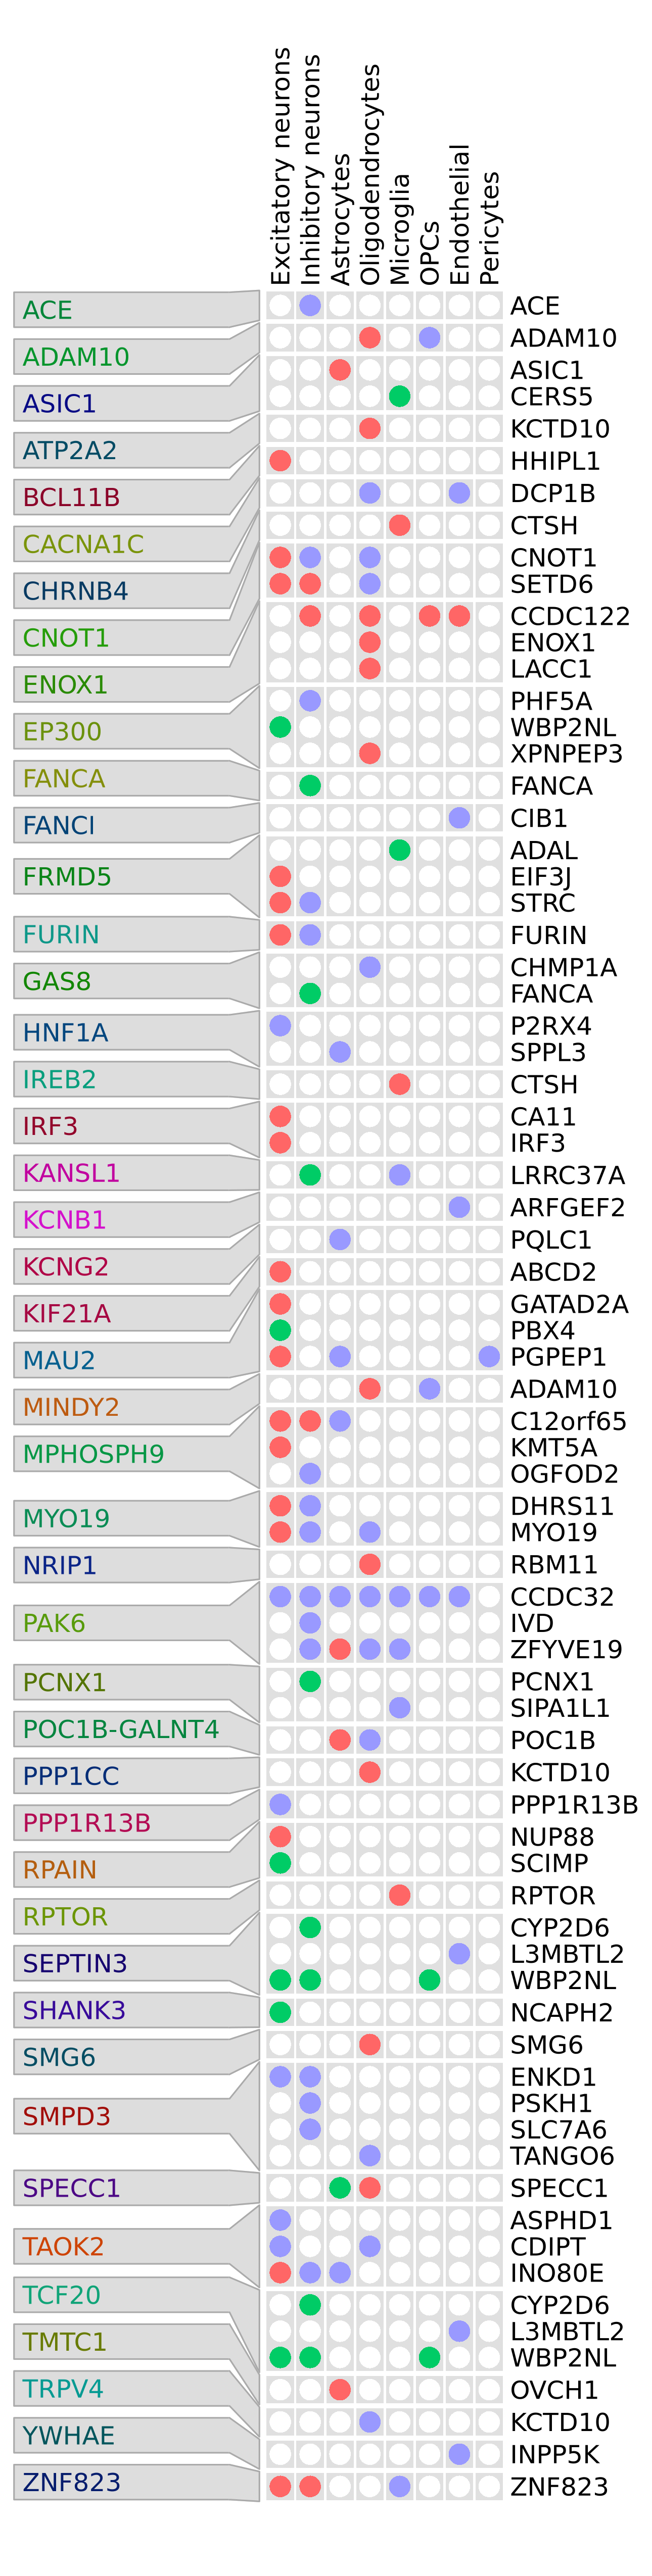

In [41]:
## chr12-22
mat_reorder = mat[,c(3,4,1,6,5,7,2,8)]
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)
options(repr.plot.width=4.3, repr.plot.height=17, repr.plot.res=300)
col_fun = colorRamp2(c(0, 1, 2, 3), c("grey", "red", "green", "blue"))
colors = structure(c("#FFFFFF", "#FF6666", "#00CC66", "#9999FF"), names = c(0,1,2,3))
# cyto = sapply(eqtl_comb_sig_wide$locus, get_cytoband)
split = eqtl_comb_sig_wide$closest_gene
# split = paste(cyto, split)
text = as.list(unique(split))
names(text) = unique(split)
Heatmap(mat_reorder, col=colors, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE,
        cell_fun = function(j, i, x, y, width, height, fill) {
            grid.rect(x = x, y = y, width = unit(4.6, 'mm'), height = unit(4.6, 'mm'),
                     gp = gpar(fill = '#E0E0E0', col = NA))
           grid.circle(x = x, y = y, r = unit(1.8, "mm"), 
                gp = gpar(fill = colors[[mat_reorder[i, j]+1]], col = NA))
           },
        right_annotation=rowAnnotation(labels = anno_text(eqtl_comb_sig_wide$symbol, which='row'), gp = gpar(fontsize = 8)),
        top_annotation=columnAnnotation(labels = anno_text(sorted_cell_names, which='column', just='left', location=unit(0, 'npc')), gp = gpar(fontsize = 10)),
        column_names_side = c("top"),
        row_title_gp = gpar(fontsize = 12),
        row_title_rot = 0,
       width = ncol(mat)*unit(5, "mm"),
       height = nrow(mat)*unit(5, "mm"),
       row_split=split,
        row_title=NULL,
        left_annotation = rowAnnotation(Locus = anno_textbox(split, text, side='left')),
       column_gap = unit(0, "mm"), border = FALSE,
       show_column_names=TRUE, show_heatmap_legend=FALSE,
       heatmap_legend_param = list(title='', 
                                   labels=c('Null', 'Shared', 'Only single cell', 'Only IBSEP'),
                                  grid_height = unit(5, "mm"), grid_width = unit(5, "mm"),
                                   labels_gp = gpar(fontsize = 14))
        )

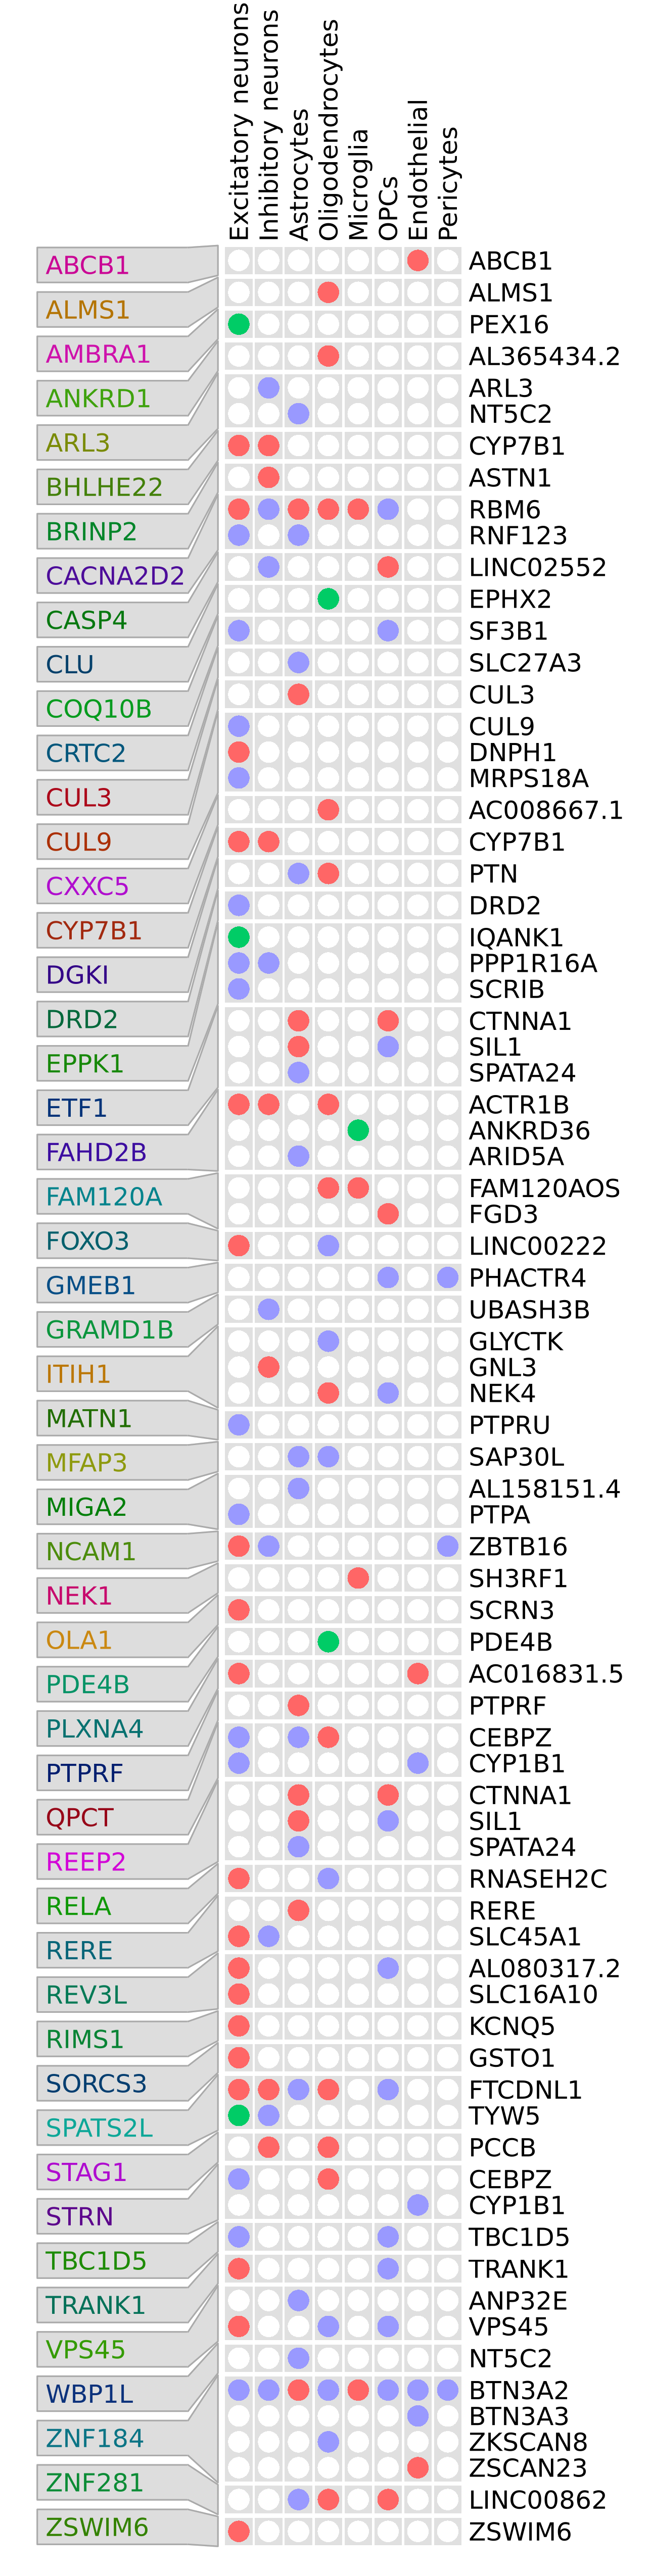

In [33]:
## chr1-11
mat_reorder = mat[,c(3,4,1,6,5,7,2,8)]
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)
options(repr.plot.width=4.3, repr.plot.height=17, repr.plot.res=300)
col_fun = colorRamp2(c(0, 1, 2, 3), c("grey", "red", "green", "blue"))
colors = structure(c("#FFFFFF", "#FF6666", "#00CC66", "#9999FF"), names = c(0,1,2,3))
# cyto = sapply(eqtl_comb_sig_wide$locus, get_cytoband)
split = eqtl_comb_sig_wide$closest_gene
# split = paste(cyto, split)
text = as.list(unique(split))
names(text) = unique(split)
Heatmap(mat_reorder, col=colors, rect_gp = gpar(type = "none"),
        cluster_rows = FALSE, cluster_columns = FALSE,
        cell_fun = function(j, i, x, y, width, height, fill) {
            grid.rect(x = x, y = y, width = unit(4.6, 'mm'), height = unit(4.6, 'mm'),
                     gp = gpar(fill = '#E0E0E0', col = NA))
           grid.circle(x = x, y = y, r = unit(1.8, "mm"), 
                gp = gpar(fill = colors[[mat_reorder[i, j]+1]], col = NA))
           },
        right_annotation=rowAnnotation(labels = anno_text(eqtl_comb_sig_wide$symbol, which='row'), gp = gpar(fontsize = 8)),
        top_annotation=columnAnnotation(labels = anno_text(sorted_cell_names, which='column', just='left', location=unit(0, 'npc')), gp = gpar(fontsize = 10)),
        column_names_side = c("top"),
        row_title_gp = gpar(fontsize = 12),
        row_title_rot = 0,
       width = ncol(mat)*unit(5, "mm"),
       height = nrow(mat)*unit(5, "mm"),
       row_split=split,
        row_title=NULL,
        left_annotation = rowAnnotation(Locus = anno_textbox(split, text, side='left')),
       column_gap = unit(0, "mm"), border = FALSE,
       show_column_names=TRUE, show_heatmap_legend=FALSE,
       heatmap_legend_param = list(title='', 
                                   labels=c('Null', 'Shared', 'Only single cell', 'Only IBSEP'),
                                  grid_height = unit(5, "mm"), grid_width = unit(5, "mm"),
                                   labels_gp = gpar(fontsize = 14))
        )